### Importing required Libraries

In [1]:
import numpy as np
import cv2
from PIL import Image
import math
from pylab import *
from scipy import ndimage
import matplotlib.pyplot as plt
import os
from scipy import misc
import skimage
from scipy.stats import multivariate_normal

### A two-dimensional Gaussian mask G(gaussian_mask) G(x)

In [2]:
def GaussianMask(sigma, size):
    mid = int(size/2.0)
    gaussian_mask = np.zeros((size,size))
    
    # constant used in the Gaussian function
    const = 1.0/(2*math.pi*(sigma**2))

    for i in range(-mid,mid+1):
        for j in range(-mid,mid+1):

            # power used in the Gaussian function
            power = (-1)*(i*i + j*j)/(2*sigma*sigma)
            gaussian_mask[i+mid][j+mid] = const*np.exp(power)
            
    return gaussian_mask

### Pyramid of Image

In [3]:
def pyramidImage(I):
    
    # Pyramid of image without any modification except scaling
    pyramid_image = []
    row,column = I.shape
    # print(row,column)
    
    # Doubling the image size initially for blurring
    I_ = cv2.resize(I, dsize = (2*column,2*row))
    pyramid_image.append(I_)
    pyramid_image.append(I)
    
    for i in range(2, octaves_count):
        
        # Divide the image row and column by 2 in each iteration
        row = int(row/2)
        column = int(column/2)
        pyramid_image.append(cv2.resize(I, dsize = (column,row)))
    
    return pyramid_image
    

Plotting the original image pyramid...


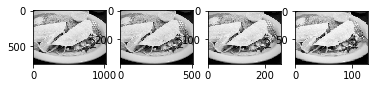

In [4]:
img = Image.open("/Users/abhianshusingla/Downloads/food-101/images/tacos/6229.jpg").convert('L')
I = np.array(img).astype('float64')

octaves_count = 4
pyramid_image = pyramidImage(I)
print("Plotting the original image pyramid...")
for oc in range(octaves_count):
    ax = plt.subplot(1,octaves_count,oc+1)
    ax.imshow(pyramid_image[oc], cmap = 'gray', aspect = 1)

plt.show()

### Pyramid of Gaussian Image

In [5]:
def pyramidGaussian(pyramid_image,octaves_count, scale_count, sigma, size):
    # Starting Scale of gaussian Pyramid 
    k = 1
    
    pyramid_gaussian_image = []
    
    for oc in range(octaves_count):
        sigma = k * sigma
        k = k * 2
        scaled_gaussian_image = []
        for sc in range(scale_count + 3):
            gaussian_mask = GaussianMask(2**(sc/scale_count) * sigma, size)
            
            # cv2.filter2D convolves the image I with Gaussian Kernel diff at level k + i - 1
            scaled_gaussian_image.append(cv2.filter2D(pyramid_image[oc], -1, gaussian_mask))
            
        pyramid_gaussian_image.append(scaled_gaussian_image)
        
    return pyramid_gaussian_image

Plotting the gaussian images pyramid...


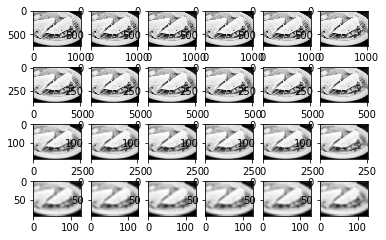

In [6]:
octaves_count = 4
scale_count = 3
sigma = 1.6
size = 7
pyramid_gaussian_image = pyramidGaussian(pyramid_image,octaves_count, scale_count, sigma, size)
print("Plotting the gaussian images pyramid...")
for oc in range(octaves_count):
    for sc in range(scale_count+3):
#         f,ax = plt.subplots(1,1)
#         ax.imshow(pyramid_gaussian_image[oc][sc], cmap = 'gray')
        
        ax = plt.subplot(octaves_count,scale_count+3, oc * (scale_count + 3) + sc + 1)
        ax.imshow(pyramid_gaussian_image[oc][sc], cmap = 'gray')
        

plt.show()

### Difference of Gaussians pyramid
### G(x, y, kσ) − G(x, y, σ) ≈ (k − 1)σ2∇2G

In [8]:
def pyramidDoG(pyramid_gaussian_image):
    
    # Pyramid of Difference of Gaussian Images
    pyramid_DoG = []
    
    # Octave Count
    for oc in range(octaves_count):
        
        # Scales in octave
        scaled_DoG = []
        
        # DoG - Scale Count + 2 in each octave
        for sc in range(scale_count + 2):
            scaled_DoG.append(pyramid_gaussian_image[oc][sc+1] - pyramid_gaussian_image[oc][sc])
            
        pyramid_DoG.append(scaled_DoG)
        
    return pyramid_DoG

Plotting the DoG...


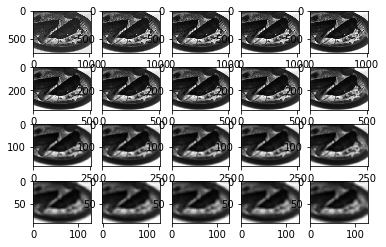

In [9]:
pyramid_DoG = pyramidDoG(pyramid_gaussian_image)
print("Plotting the DoG...")
for oc in range(octaves_count):
    for sc in range(scale_count+2):
        ax = plt.subplot(octaves_count,scale_count+2, oc * (scale_count + 2) + sc + 1)
        ax.imshow(pyramid_DoG[oc][sc], cmap = 'gray')
        # print(pyramid_DoG[oc][sc].shape, type(pyramid_DoG[oc][sc][0][0]))

plt.show()

# 1. Scale Space Peak Detection

### Computing Maxima or Minima extrema at a given octave and a scale 

In [10]:
def max_min_extrema(pyramid_DoG, oc, sc):
    
    # Size of DoG image at octave oc 
    row,column = pyramid_DoG[oc][sc].shape
    
    # All the extrema points at a given scale
    points = []
    
    # Check the minima and maxima pixel by pixel
    for i in range(1, row - 1):
        for j in range(1, column - 1):
            
            # Maximum among 8 neighbours at the actual scale of the image
            max1 = np.max(pyramid_DoG[oc][sc][i-1:i+2, j-1:j+2])
            
            # Maximum among 9 neighbours at scale below the given scale
            max2 = np.amax(pyramid_DoG[oc][sc - 1][i-1:i+2, j-1:j+2])
            
            # Maximum among 9 neighbours at scale above the given scale
            max3 = np.amax(pyramid_DoG[oc][sc + 1][i-1:i+2, j-1:j+2])
            
            # Minimum among 8 neighbours at the actual scale of the image
            min1 = np.amin(pyramid_DoG[oc][sc][i-1:i+2, j-1:j+2])
            
            # Minimum among 9 neighbours at scale below the given scale
            min2 = np.amin(pyramid_DoG[oc][sc - 1][i-1:i+2, j-1:j+2])
            
            # Minimum among 9 neighbours at scale above the given scale
            min3 = np.amin(pyramid_DoG[oc][sc + 1][i-1:i+2, j-1:j+2])
            
            # Check if maxima or minima among all 26 neighbours
            if(pyramid_DoG[oc][sc][i][j] == max(max1,max2,max3) or pyramid_DoG[oc][sc][i][j] == min(min1,min2,min3)):
                points.append((i,j))
                
    return points

### Computing Maxima or Minima extrema at a given octave and a scale
#### Using numpy shifted matrices to perform this operation on overall image to make it computationally faster

In [11]:
def max_min_extrema2(pyramid_DoG, oc, sc):
    
    # Size of DoG image at octave oc 
    row,column = pyramid_DoG[oc][0].shape
    
    # All the extrema points at a given scale
    points = []
    
    # Up Shift the matrix and pad the last row with 0
    Matrix1 = pyramid_DoG[oc][sc][1:row,:]
    Matrix1 = np.pad(Matrix1,[(0, 1), (0, 0)], 'constant', constant_values=(0))
    
    # Down Shift the matrix and pad the first row with 0
    Matrix2 = pyramid_DoG[oc][sc][0:row - 1,:]
    Matrix2 = np.pad(Matrix2,[(1, 0), (0, 0)], 'constant', constant_values=(0))
    
    # Left Shift the matrix and pad the last column with 0
    Matrix3 = pyramid_DoG[oc][sc][:,1:column]
    Matrix3 = np.pad(Matrix3,[(0, 0), (0, 1)], 'constant', constant_values=(0))
    
    # Right Shift the matrix and pad the first column with 0
    Matrix4 = pyramid_DoG[oc][sc][:,0:column-1]
    Matrix4 = np.pad(Matrix4,[(0, 0), (1, 0)], 'constant', constant_values=(0))
    
    # Up Shift and left shift the matrix and pad the last row and last column with 0
    Matrix5 = pyramid_DoG[oc][sc][1:row,1:column]
    Matrix5 = np.pad(Matrix5,[(0, 1), (0, 1)], 'constant', constant_values=(0))
    
    # Down Shift and right shift the matrix and pad the first row and first column with 0
    Matrix6 = pyramid_DoG[oc][sc][0:row - 1,0:column-1]
    Matrix6 = np.pad(Matrix6,[(1, 0), (1, 0)], 'constant', constant_values=(0))
    
    # Down Shift and left shift the matrix and pad the first row and last column with 0
    Matrix7 = pyramid_DoG[oc][sc][0:row - 1,1:column]
    Matrix7 = np.pad(Matrix7,[(1, 0), (0, 1)], 'constant', constant_values=(0))
    
    # Up Shift and right shift the matrix and pad the last row and first column with 0
    Matrix8 = pyramid_DoG[oc][sc][1:row,0:column-1]
    Matrix8 = np.pad(Matrix8,[(0, 1), (1, 0)], 'constant', constant_values=(0))
    
    # Do the same shifting for scale below the given scale
    Matrix11 = pyramid_DoG[oc][sc-1][1:row,:]
    Matrix11 = np.pad(Matrix11,[(0, 1), (0, 0)], 'constant', constant_values=(0))
    
    Matrix12 = pyramid_DoG[oc][sc-1][0:row - 1,:]
    Matrix12 = np.pad(Matrix12,[(1, 0), (0, 0)], 'constant', constant_values=(0))
    
    Matrix13 = pyramid_DoG[oc][sc-1][:,1:column]
    Matrix13 = np.pad(Matrix13,[(0, 0), (0, 1)], 'constant', constant_values=(0))
    
    Matrix14 = pyramid_DoG[oc][sc-1][:,0:column-1]
    Matrix14 = np.pad(Matrix14,[(0, 0), (1, 0)], 'constant', constant_values=(0))
    
    Matrix15 = pyramid_DoG[oc][sc-1][1:row,1:column]
    Matrix15 = np.pad(Matrix15,[(0, 1), (0, 1)], 'constant', constant_values=(0))
    
    Matrix16 = pyramid_DoG[oc][sc-1][0:row - 1,0:column-1]
    Matrix16 = np.pad(Matrix16,[(1, 0), (1, 0)], 'constant', constant_values=(0))
    
    Matrix17 = pyramid_DoG[oc][sc-1][0:row - 1,1:column]
    Matrix17 = np.pad(Matrix17,[(1, 0), (0, 1)], 'constant', constant_values=(0))
    
    Matrix18 = pyramid_DoG[oc][sc-1][1:row,0:column-1]
    Matrix18 = np.pad(Matrix18,[(0, 1), (1, 0)], 'constant', constant_values=(0))
    
    # Do the same shifting for scale above the given scale
    Matrix21 = pyramid_DoG[oc][sc+1][1:row,:]
    Matrix21 = np.pad(Matrix21,[(0, 1), (0, 0)], 'constant', constant_values=(0))
    
    Matrix22 = pyramid_DoG[oc][sc+1][0:row - 1,:]
    Matrix22 = np.pad(Matrix22,[(1, 0), (0, 0)], 'constant', constant_values=(0))
    
    Matrix23 = pyramid_DoG[oc][sc+1][:,1:column]
    Matrix23 = np.pad(Matrix23,[(0, 0), (0, 1)], 'constant', constant_values=(0))
    
    Matrix24 = pyramid_DoG[oc][sc+1][:,0:column-1]
    Matrix24 = np.pad(Matrix24,[(0, 0), (1, 0)], 'constant', constant_values=(0))
    
    Matrix25 = pyramid_DoG[oc][sc+1][1:row,1:column]
    Matrix25 = np.pad(Matrix25,[(0, 1), (0, 1)], 'constant', constant_values=(0))
    
    Matrix26 = pyramid_DoG[oc][sc+1][0:row - 1,0:column-1]
    Matrix26 = np.pad(Matrix26,[(1, 0), (1, 0)], 'constant', constant_values=(0))
    
    Matrix27 = pyramid_DoG[oc][sc+1][0:row - 1,1:column]
    Matrix27 = np.pad(Matrix27,[(1, 0), (0, 1)], 'constant', constant_values=(0))
    
    Matrix28 = pyramid_DoG[oc][sc+1][1:row,0:column-1]
    Matrix28 = np.pad(Matrix28,[(0, 1), (1, 0)], 'constant', constant_values=(0))

    # Maximum among 8 neighbours at the actual scale of the image
    max1 = np.maximum(pyramid_DoG[oc][sc], np.maximum(
                      np.maximum(np.maximum(Matrix1, Matrix2), np.maximum(Matrix3, Matrix4)), 
                      np.maximum(np.maximum(Matrix5, Matrix6), np.maximum(Matrix7, Matrix8))))
    
    # Maximum among 9 neighbours at scale below the given scale
    max2 = np.maximum(pyramid_DoG[oc][sc-1], np.maximum(
                      np.maximum(np.maximum(Matrix11, Matrix12), np.maximum(Matrix13, Matrix14)), 
                      np.maximum(np.maximum(Matrix15, Matrix16), np.maximum(Matrix17, Matrix18))))
    
    # Maximum among 9 neighbours at scale above the given scale
    max3 = np.maximum(pyramid_DoG[oc][sc+1], np.maximum(
                      np.maximum(np.maximum(Matrix21, Matrix22), np.maximum(Matrix23, Matrix24)), 
                      np.maximum(np.maximum(Matrix25, Matrix26), np.maximum(Matrix27, Matrix28))))
    
    # Minimum among 8 neighbours at the actual scale of the image
    min1 = np.minimum(pyramid_DoG[oc][sc], np.minimum(
                      np.minimum(np.minimum(Matrix1, Matrix2), np.minimum(Matrix3, Matrix4)), 
                      np.minimum(np.minimum(Matrix5, Matrix6), np.minimum(Matrix7, Matrix8))))
    
    # Minimum among 9 neighbours at scale below the given scale
    min2 = np.minimum(pyramid_DoG[oc][sc-1], np.minimum(
                      np.minimum(np.minimum(Matrix11, Matrix12), np.minimum(Matrix13, Matrix14)), 
                      np.minimum(np.minimum(Matrix15, Matrix16), np.minimum(Matrix17, Matrix18))))
    
    # Minimum among 9 neighbours at scale above the given scale
    min3 = np.minimum(pyramid_DoG[oc][sc+1], np.maximum(
                      np.minimum(np.minimum(Matrix21, Matrix22), np.minimum(Matrix23, Matrix24)), 
                      np.minimum(np.minimum(Matrix25, Matrix26), np.minimum(Matrix27, Matrix28))))
    
    # maxima or minima among all 26 neighbours
    max_ = np.maximum(max1, np.maximum(max2, max3))
    min_ = np.minimum(min1, np.minimum(min2, min3))
    
    peaks = np.logical_or(np.equal(pyramid_DoG[oc][sc], max_), np.equal(pyramid_DoG[oc][sc], min_))
    
    return peaks

### Extrema at all scales

In [ ]:
def scale_space_peaks(pyramid_DoG):
    
    # Pyramid of peaks at different octaves and scales
    pyramid_peaks = []
    for oc in range(octaves_count):
        
        scaled_peaks = []
        for sc in range(1, scale_count + 1):
            
            # Same result but taking longer time to compute this pixel by pixel, so use shifted numpy matrices 
            # peaks = max_min_extrema(pyramid_DoG,oc,sc)
            peaks = max_min_extrema2(pyramid_DoG,oc,sc)
            scaled_peaks.append(peaks)
            
            print("Number of peaks detected after maxima-minima extrema at octave ",oc, "and scale ", sc-1, " is ", np.sum(peaks))
        
        pyramid_peaks.append(scaled_peaks)

    return pyramid_peaks

Number of peaks detected after maxima-minima extrema at octave  0 and scale  0  is  9711
Number of peaks detected after maxima-minima extrema at octave  0 and scale  1  is  14039
Number of peaks detected after maxima-minima extrema at octave  0 and scale  2  is  9967
Number of peaks detected after maxima-minima extrema at octave  1 and scale  0  is  2070
Number of peaks detected after maxima-minima extrema at octave  1 and scale  1  is  2070
Number of peaks detected after maxima-minima extrema at octave  1 and scale  2  is  2070
Number of peaks detected after maxima-minima extrema at octave  2 and scale  0  is  168
Number of peaks detected after maxima-minima extrema at octave  2 and scale  1  is  168
Number of peaks detected after maxima-minima extrema at octave  2 and scale  2  is  168
Number of peaks detected after maxima-minima extrema at octave  3 and scale  0  is  12
Number of peaks detected after maxima-minima extrema at octave  3 and scale  1  is  12
Number of peaks detected af

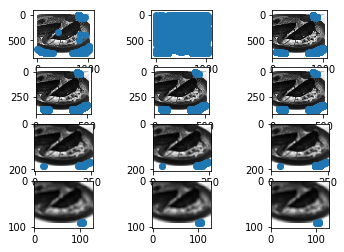

In [13]:
pyramid_peaks = scale_space_peaks(pyramid_DoG)
print(type(pyramid_peaks[0][0][0][0]))
print("Plotting the Maxima Minima Extrema...")
for oc in range(octaves_count):
    for sc in range(scale_count):
        idx = np.where(pyramid_peaks[oc][sc])
        ax = plt.subplot(octaves_count,scale_count, oc * (scale_count) + sc + 1)
        ax.imshow(pyramid_DoG[oc][sc+1], cmap = 'gray')
        plt.scatter(idx[1], idx[0])
plt.show()

# 2. KeyPoint Localization

### 1. Initial Rejection - Reject low threshold values
### 2. Further Outlier Rejection - Reject poorly localised candidates along an edge

### Compute Hessian Matrix

In [14]:
def HessianMatrix(pyramid_DoG,pyramid_peaks):
    
    # Scale
    image_scale = 1.0/255
    
    # Derivative scales for used for Hessian Matrix
    first_derivative_scale = image_scale * 0.5
    second_derivative_scale = image_scale
    cross_derivative_scale = image_scale * 0.25
    
    # For each octave
    for oc in range(octaves_count):
        
        # For each scale in the octave
        for sc in range(1, scale_count + 1):
            
            row, column = pyramid_DoG[oc][sc-1].shape
            
            # calculate the hessian matrix pixel by pixel
            for i in range(1,row-1):
                for j in range(1,column-1):
                    
                    # If there is peak detected at a particuar pixel from the scale space extrema
                    if(pyramid_peaks[oc][sc-1][i][j]):
                        
                        # First order derivatives in x and y directions and scales
                        Dx = (pyramid_DoG[oc][sc][i][j+1] - pyramid_DoG[oc][sc][i][j-1]) * first_derivative_scale
                        Dy = (pyramid_DoG[oc][sc][i+1][j] - pyramid_DoG[oc][sc][i-1][j]) * first_derivative_scale
                        Ds = (pyramid_DoG[oc][sc+1][i][j] - pyramid_DoG[oc][sc-1][i][j]) * first_derivative_scale

                        # Second order derivatives for all three values-x, y and scale
                        Dxx = (pyramid_DoG[oc][sc][i][j+1] + pyramid_DoG[oc][sc][i][j-1] 
                               - 2 * pyramid_DoG[oc][sc][i][j]) * second_derivative_scale
                        Dyy = (pyramid_DoG[oc][sc][i+1][j] + pyramid_DoG[oc][sc][i-1][j] 
                               - 2 * pyramid_DoG[oc][sc][i][j]) * second_derivative_scale
                        Dss = (pyramid_DoG[oc][sc+1][i][j] + pyramid_DoG[oc][sc-1][i][j] 
                               - 2 * pyramid_DoG[oc][sc][i][j]) * second_derivative_scale
                        
                        # Cross Order derivatives for x,y and scales
                        Dxy = (pyramid_DoG[oc][sc][i+1][j+1] + pyramid_DoG[oc][sc][i-1][j-1] 
                               - pyramid_DoG[oc][sc][i+1][j-1] - pyramid_DoG[oc][sc][i-1][j+1]) * cross_derivative_scale

                        Dxs = (pyramid_DoG[oc][sc+1][i][j+1] + pyramid_DoG[oc][sc-1][i][j-1] 
                               - pyramid_DoG[oc][sc+1][i][j-1] - pyramid_DoG[oc][sc-1][i][j+1]) * cross_derivative_scale

                        Dys = (pyramid_DoG[oc][sc+1][i+1][j] + pyramid_DoG[oc][sc-1][i-1][j] 
                               - pyramid_DoG[oc][sc-1][i+1][j] - pyramid_DoG[oc][sc+1][i-1][j]) * cross_derivative_scale
                        
                        # First order derivative matrix - dD
                        dD = np.matrix([[Dx], [Dy], [Ds]])
                        
                        # Hessian Matrix
                        H = np.matrix([[Dxx, Dxy, Dxs], [Dxy, Dyy, Dys], [Dxs, Dys, Dss]])
                        
                        # x_hat obtained by second order derivative(H) with respect to dD
                        x_hat = np.linalg.lstsq(H, dD)[0]
                        
                        # Localization obtained by Taylor Series Expansion and substituting x_hat in the equation
                        D_x_hat = pyramid_DoG[oc][sc][i][j] + 0.5 * np.dot(dD.transpose(), x_hat)

                        # Experimental results show that r = 10 gives the best result
                        r = 10.0
                        
                        # Eliminating poor edge responses
                        # (Dxx + Dyy) ** 2) * r) < (Dxx * Dyy - (Dxy ** 2)) * (((r + 1) ** 2)
                        
                        # Rejecting unstable extrema with low contrast
                        # |D_x_hat| > 0.03
                        
                        # If x_hat > 0.5 in any of the directions, then it means that it is closer to a different sample point
                        if (((Dxx + Dyy) ** 2) * r) < (Dxx * Dyy - (Dxy ** 2)) * (((r + 1) ** 2)) and np.absolute(x_hat[0]) < 0.5 and np.absolute(x_hat[1]) < 0.5 and np.absolute(x_hat[2]) < 0.5 and np.absolute(D_x_hat) > 0.03:
                            pyramid_peaks[oc][sc-1][i][j] = True
                        else:
                            pyramid_peaks[oc][sc-1][i][j] = False
            
            print("Number of peaks detected after eliminating low edge response at octave ",oc, "and scale ", sc-1, " is ", np.sum(pyramid_peaks[oc][sc-1]))
    
            
    return pyramid_peaks
            

Number of peaks detected after eliminating low edge response at octave  0 and scale  0  is  317
Number of peaks detected after eliminating low edge response at octave  0 and scale  1  is  2549
Number of peaks detected after eliminating low edge response at octave  0 and scale  2  is  284
Number of peaks detected after eliminating low edge response at octave  1 and scale  0  is  135
Number of peaks detected after eliminating low edge response at octave  1 and scale  1  is  135
Number of peaks detected after eliminating low edge response at octave  1 and scale  2  is  135
Number of peaks detected after eliminating low edge response at octave  2 and scale  0  is  26
Number of peaks detected after eliminating low edge response at octave  2 and scale  1  is  26
Number of peaks detected after eliminating low edge response at octave  2 and scale  2  is  26
Number of peaks detected after eliminating low edge response at octave  3 and scale  0  is  8
Number of peaks detected after eliminating l

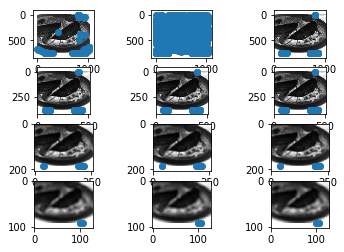

In [15]:
pyramid_peaks = HessianMatrix(pyramid_DoG,pyramid_peaks)
print("Plotting the Maxima Minima Extrema...")
for oc in range(octaves_count):
    for sc in range(scale_count):
        idx = np.where(pyramid_peaks[oc][sc])
        ax = plt.subplot(octaves_count,scale_count, oc * (scale_count) + sc + 1)
        ax.imshow(pyramid_DoG[oc][sc+1], cmap = 'gray')
        plt.scatter(idx[1], idx[0])
plt.show()

In [16]:
def HessianMatrix2(pyramid_DoG,pyramid_peaks,edge_threshold):
    image_scale = 1.0/255
    first_derivative_scale = image_scale * 0.5
    second_derivative_scale = image_scale
    cross_derivative_scale = image_scale * 0.25
    
    for oc in range(octaves_count):

        for sc in range(1, scale_count + 1):
            
            row,column = pyramid_DoG[oc][sc].shape
            
            # Up Shift the matrix and pad the last row with 0
            Matrix1 = pyramid_DoG[oc][sc][1:row,:]
            Matrix1 = np.pad(Matrix1,[(0, 1), (0, 0)], 'constant', constant_values=(0))

            # Down Shift the matrix and pad the first row with 0
            Matrix2 = pyramid_DoG[oc][sc][0:row - 1,:]
            Matrix2 = np.pad(Matrix2,[(1, 0), (0, 0)], 'constant', constant_values=(0))
            
            # Left Shift the matrix and pad the last column with 0
            Matrix3 = pyramid_DoG[oc][sc][:,1:column]
            Matrix3 = np.pad(Matrix3,[(0, 0), (0, 1)], 'constant', constant_values=(0))

            # Right Shift the matrix and pad the first column with 0
            Matrix4 = pyramid_DoG[oc][sc][:,0:column-1]
            Matrix4 = np.pad(Matrix4,[(0, 0), (1, 0)], 'constant', constant_values=(0))
            
            # Up Shift and left shift the matrix and pad the last row and last column with 0
            Matrix5 = pyramid_DoG[oc][sc][1:row,1:column]
            Matrix5 = np.pad(Matrix5,[(0, 1), (0, 1)], 'constant', constant_values=(0))

            # Down Shift and right shift the matrix and pad the first row and first column with 0
            Matrix6 = pyramid_DoG[oc][sc][0:row - 1,0:column-1]
            Matrix6 = np.pad(Matrix6,[(1, 0), (1, 0)], 'constant', constant_values=(0))

            # Down Shift and left shift the matrix and pad the first row and last column with 0
            Matrix7 = pyramid_DoG[oc][sc][0:row - 1,1:column]
            Matrix7 = np.pad(Matrix7,[(1, 0), (0, 1)], 'constant', constant_values=(0))

            # Up Shift and right shift the matrix and pad the last row and first column with 0
            Matrix8 = pyramid_DoG[oc][sc][1:row,0:column-1]
            Matrix8 = np.pad(Matrix8,[(0, 1), (1, 0)], 'constant', constant_values=(0))
            
            # Up Shift the matrix and pad the last row with 0
            Matrix11 = pyramid_DoG[oc][sc-1][1:row,:]
            Matrix11 = np.pad(Matrix11,[(0, 1), (0, 0)], 'constant', constant_values=(0))

            # Down Shift the matrix and pad the first row with 0
            Matrix12 = pyramid_DoG[oc][sc-1][0:row - 1,:]
            Matrix12 = np.pad(Matrix12,[(1, 0), (0, 0)], 'constant', constant_values=(0))
            
            # Left Shift the matrix and pad the last column with 0
            Matrix13 = pyramid_DoG[oc][sc-1][:,1:column]
            Matrix13 = np.pad(Matrix13,[(0, 0), (0, 1)], 'constant', constant_values=(0))

            # Right Shift the matrix and pad the first column with 0
            Matrix14 = pyramid_DoG[oc][sc-1][:,0:column-1]
            Matrix14 = np.pad(Matrix14,[(0, 0), (1, 0)], 'constant', constant_values=(0))
            
            # Up Shift the matrix and pad the last row with 0
            Matrix21 = pyramid_DoG[oc][sc+1][1:row,:]
            Matrix21 = np.pad(Matrix21,[(0, 1), (0, 0)], 'constant', constant_values=(0))

            # Down Shift the matrix and pad the first row with 0
            Matrix22 = pyramid_DoG[oc][sc+1][0:row - 1,:]
            Matrix22 = np.pad(Matrix22,[(1, 0), (0, 0)], 'constant', constant_values=(0))
            
            # Left Shift the matrix and pad the last column with 0
            Matrix23 = pyramid_DoG[oc][sc+1][:,1:column]
            Matrix23 = np.pad(Matrix23,[(0, 0), (0, 1)], 'constant', constant_values=(0))

            # Right Shift the matrix and pad the first column with 0
            Matrix24 = pyramid_DoG[oc][sc+1][:,0:column-1]
            Matrix24 = np.pad(Matrix24,[(0, 0), (1, 0)], 'constant', constant_values=(0))
            
            # First order derivatives in x and y directions and scales
            Dx = (Matrix4 - Matrix3) * first_derivative_scale
            Dy = (Matrix1 - Matrix2) * first_derivative_scale
            Ds = (pyramid_DoG[oc][sc+1] - pyramid_DoG[oc][sc-1]) * first_derivative_scale
            
            # Second order derivatives for all three values-x, y and scale
            Dxx = (Matrix4 + Matrix3 - 2 * pyramid_DoG[oc][sc]) * second_derivative_scale
            Dyy = (Matrix1 + Matrix2 - 2 * pyramid_DoG[oc][sc]) * second_derivative_scale
            Dss = (pyramid_DoG[oc][sc+1] + pyramid_DoG[oc][sc-1] - 2 * pyramid_DoG[oc][sc]) * second_derivative_scale
            
            # Cross order derivatives for all three values-x, y and scale
            Dxy = (Matrix5 + Matrix6 - Matrix7 - Matrix8) * cross_derivative_scale
            Dxs = (Matrix22 - Matrix21 - Matrix12 + Matrix11) * cross_derivative_scale
            Dys = (Matrix24 - Matrix23 - Matrix14 + Matrix13) * cross_derivative_scale
            
#             dD = np.matrix([[Dx], [Dy], [Ds]])
#             H = np.matrix([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
#             x_hat = numpy.linalg.lstsq(H, dD)[0]

            # No need to store Hessian Matrix
            # H = [[Dxx,Dxy,Dxs]
            #      [Dxy,Dyy,Dys]
            #      [Dxs,Dys,Dss]]
            
            # Not using eigen values as it is computationally expensive to calculate
            # Trace = Sum of Eigen Values or Sum of Diaganol Elements
            Trace = np.add(Dxx,Dyy,Dss)
            Trace_2 = np.multiply(Trace,Trace)
            
            
            # Determinant = Dxx * (Dyy * Dss - Dys * Dys) - Dxy * (Dxy * Dss - Dys * Dxs) + Dxs * (Dxy * Dys - Dyy * Dxs)
            # Determinant = Multiplication of Eigen Values or Dxx*Dyy - Dxy*Dxy
            Term1 = np.multiply(Dxx, np.multiply(Dyy,Dss) - np.multiply(Dys,Dys))
            Term2 = np.multiply(Dxy, np.multiply(Dxy,Dss) - np.multiply(Dys,Dxs))
            Term3 = np.multiply(Dxs, np.multiply(Dxy,Dys) - np.multiply(Dyy,Dxs))
            Determinant = Term1 - Term2 + Term3
            
            # Inverse of Hessian Matrix
            # inv(H) = [[a,d,g],[b,e,h],[c,f,i]]
            a = np.divide(np.multiply(Dyy,Dss) - np.multiply(Dys,Dys), Determinant)
            b = np.divide(np.multiply(Dys,Dxs) - np.multiply(Dxy,Dss), Determinant) 
            c = np.divide(np.multiply(Dxy,Dys) - np.multiply(Dyy,Dxs), Determinant)
            d = np.divide(np.multiply(Dys,Dxs) - np.multiply(Dxy,Dss), Determinant)
            e = np.divide(np.multiply(Dxx,Dys) - np.multiply(Dxs,Dxs), Determinant)
            f = np.divide(np.multiply(Dxy,Dxs) - np.multiply(Dxx,Dys), Determinant)
            g = np.divide(np.multiply(Dxy,Dys) - np.multiply(Dyy,Dxs), Determinant)
            h = np.divide(np.multiply(Dxy,Dxs) - np.multiply(Dxx,Dys), Determinant)
            i = np.divide(np.multiply(Dxx,Dyy) - np.multiply(Dxy,Dxy), Determinant)
            
            # Dot product
            x_hat_0 = np.multiply(a,Dx) + np.multiply(d,Dy) + np.multiply(g,Ds)
            x_hat_1 = np.multiply(b,Dx) + np.multiply(e,Dy) + np.multiply(h,Ds)
            x_hat_2 = np.multiply(c,Dx) + np.multiply(f,Dy) + np.multiply(i,Ds)
            
            D_x_hat = pyramid_DoG[oc][sc] + 0.5 * (np.multiply(Dx,x_hat_0) + np.multiply(Dy,x_hat_1) + np.multiply(Ds,x_hat_2))
            
            r = 10.0
            
            peaks = np.logical_and(pyramid_peaks[oc][sc-1],np.logical_and(np.less(np.absolute(x_hat_0),0.5),
                                  np.logical_and(np.less(np.absolute(x_hat_1),0.5),
                                   np.logical_and(np.less(np.absolute(x_hat_2),0.5),
                                  np.greater(np.absolute(D_x_hat),0.03)))))
            
            peaks = np.logical_and(peaks, 
                                   np.less(r * np.multiply(Dxx + Dyy,Dxx + Dyy), 
                                           (r+1)*(r+1)*(np.multiply(Dxx,Dyy) - np.multiply(Dxy,Dxy))))
                     
            pyramid_peaks[oc][sc-1] = peaks    
            
            print("Number of peaks detected after eliminating low edge response at octave ",oc, "and scale ", sc-1, " is ", np.sum(peaks))
    
            
    return pyramid_peaks  

In [ ]:
# # Ignore numpy RuntimeWarning: divide by zero encountered in true_divide and RuntimeWarning: invalid value encountered in true_divide
# np.seterr(divide = 'ignore', invalid = 'ignore')
# edge_threshold = 10.0
# pyramid_ratio = HessianMatrix2(pyramid_DoG,pyramid_peaks,edge_threshold)

# print("Plotting the Maxima Minima Extrema...")
# for oc in range(octaves_count):
#     for sc in range(scale_count):
#         idx = np.where(pyramid_peaks[oc][sc])
#         ax = plt.subplot(octaves_count,scale_count, oc * (scale_count) + sc + 1)
#         ax.imshow(pyramid_DoG[oc][sc+1], cmap = 'gray')
#         plt.scatter(idx[1], idx[0])
# plt.show()

# 3. Orientation Assignment

### Construction of 2 pyramids A and B for calculating Magnitude and Direction 
### A = L(x+1,y) - L(x-1,y) and B = L(x,y+1) - L(x,y-1)

In [17]:
def pyramid_ab(pyramid_gaussian_image):
    
    # Pyramids of A and B where A = L(x+1,y) - L(x-1,y) and B = L(x,y+1) - L(x,y-1)
    # L(x,y) is the smoothed image
    pyramid_a = []
    pyramid_b = []
    
    for oc in range(octaves_count):
        
        # Image Size at octave level oc
        row, column = pyramid_gaussian_image[oc][0].shape
        scaled_a = []
        scaled_b = []
        
        for sc in range(scale_count):
        
            # Making numpy matrices A and B to reduce the overall calculation time for magnitudes and directions
            A = np.subtract(pyramid_gaussian_image[oc][sc+1][2:row,:], pyramid_gaussian_image[oc][sc+1][0:row-2,:])
            B = np.subtract(pyramid_gaussian_image[oc][sc+1][:,2:column], pyramid_gaussian_image[oc][sc+1][:,0:column-2])

            # Padding along only first and last row to make the shape equal to original scaled image shape
            A = np.pad(A,[(1, 1), (0, 0)], 'constant', constant_values=(0))

            # Padding along first and last column to make the shape equal to original scaled image shape
            B = np.pad(B,[(0, 0), (1, 1)], 'constant', constant_values=(0))
            
            scaled_a.append(A)
            scaled_b.append(B)

        pyramid_a.append(scaled_a)
        pyramid_b.append(scaled_b)
        
    return pyramid_a, pyramid_b

In [18]:
pyramid_a, pyramid_b = pyramid_ab(pyramid_gaussian_image)

### Central Derivative Magnitudes
### Magnitude = sqrt( sq( L(x+1,y) - L(x-1,y) ) + sq( L(x,y+1) - L(x,y-1) ) )

In [19]:
def magnitude(pyramid_a, pyramid_b):
    
    # Pyramids of magnitude matrices
    pyramid_magnitude = []
    for oc in range(octaves_count):
        
        scaled_magnitude = []
        for sc in range(scale_count):
            
            # magnitude = sqrt( sq( L(x+1,y) - L(x-1,y) ) + sq( L(x,y+1) - L(x,y-1) ) )
            mag = np.sqrt(np.add(np.multiply(pyramid_a[oc][sc],pyramid_a[oc][sc]), np.multiply(pyramid_b[oc][sc],pyramid_b[oc][sc])))
            scaled_magnitude.append(mag)
            
        pyramid_magnitude.append(scaled_magnitude)

    return pyramid_magnitude

Plotting the magnitudes...


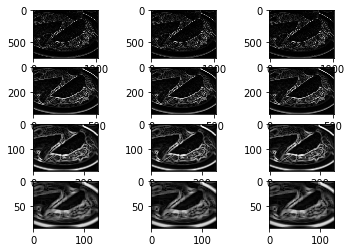

In [20]:
pyramid_magnitude = magnitude(pyramid_a, pyramid_b)

# Displaying the magnitude matrix for testing purposes
print("Plotting the magnitudes...")
for oc in range(octaves_count):
    for sc in range(scale_count):
        ax = plt.subplot(octaves_count,scale_count, oc * (scale_count) + sc + 1)
        ax.imshow(pyramid_magnitude[oc][sc], cmap = 'gray')

plt.show()

### Central Derivative Directions
### Direction =  arctan( ( L(x,y+1) - L(x,y-1) ) /  ( L(x+1,y) - L(x-1,y) ) )

In [21]:
def direction(pyramid_a, pyramid_b):
    
    # Pyramids of magnitude matrices
    pyramid_direction = []
    for oc in range(octaves_count):
        
        scaled_direction = []
        for sc in range(scale_count):
            
            # Direction = arctan( ( L(x,y+1) - L(x,y-1) ) / ( L(x+1,y) - L(x-1,y) ) )
            # Adding np.pi to make the range from (-180, 180) to (0,360)
            direct = np.degrees(np.pi + np.arctan2(pyramid_b[oc][sc], pyramid_a[oc][sc]))
            scaled_direction.append(direct)
        
        pyramid_direction.append(scaled_direction)
    
    return pyramid_direction

Plotting the directions matrix...


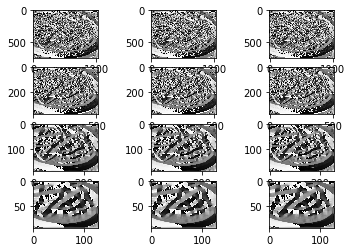

In [22]:
pyramid_direction = direction(pyramid_a, pyramid_b)

# Displaying the magnitude matrix for testing purposes
print("Plotting the directions matrix...")
for oc in range(octaves_count):
    for sc in range(scale_count):
        ax = plt.subplot(octaves_count,scale_count, oc * (scale_count) + sc + 1)
        ax.imshow(pyramid_direction[oc][sc], cmap = 'gray')

plt.show()

### Assigning orientation to the keypoints

In [23]:
def assign_orientation(pyramid_peaks,pyramid_magnitude,pyramid_direction):
    
    keypoints = []
    # Creating Histogram Pyramid for each octave
    pyramid_hist = []
    
    # Inital multiple for sigma
    k = 1
    sigma = 1.6
    
    # Scaling factor for different octaves
    # 0.5 for the upscaled image, 1 for normal image
    # 2 for halved, 4 for quadrupled images and so on..
    scale_factor = [0.5,1,2,4,8]
    
    
    for oc in range(octaves_count):
        scale_hist = []
        
        for sc in range(scale_count):
            
            # Gaussian Mask parameters
            sigma = 1.5 * k * sigma
            size = 3
            k = k * 2
            
            # Gaussian Mask
            gaussian_window = GaussianMask(2**((sc+1)/scale_count) * sigma,size)
            
            # x and y Indices where peaks are detected and localized 
            index = np.where(pyramid_peaks[oc][sc])
            
            row, column = pyramid_peaks[oc][sc].shape
            
            # For each keypoint, do the orientation assignment 
            for idx in range(len(index[0])):
            
                # Creating a 36 bin histogram for each keypoint surrounded by a 3*3 neighbourhood
                hist = np.zeros(36)

                # x and y index of keypoints
                index_i = index[0][idx]
                index_j = index[1][idx]
                
                # Check for boundary conditions
                if(index_i >= 0 and index_j >= 0 and index_i < row - 1 and index_j < column - 1):
                    # 3*3 neighbourhood
                    for i in range(-1,2):
                        for j in range(-1,2):
                            
                            # Clip the bin indices from 0 to 35
                            bin_index = int(np.clip(np.floor((pyramid_direction[oc][sc][index_i + i][index_j + j]/10)), 0, 35))
                            # Adding the magnitude to the corresponding direction bin
                            hist[bin_index] += gaussian_window[i+1][j+1] * pyramid_magnitude[oc][sc][index_i + i][index_j + j]
                    
                    if(np.max(hist) > 0):

                        # Extract the maximum value from 36 bin histogram
                        val = np.max(hist)

                        # Store the indices of those values which is above 80% of the above calculated maximum value
                        orientation_peaks = np.where(np.greater(hist, 0.8*val))
                        #print(orientation_peaks)

                        # Store the values above 80% of maximum value
                        val = np.take(hist, orientation_peaks)

                        for pk in range(len(orientation_peaks[0])):
                            # Append these direction and magnitude values for each keypoint in dirc and mag list
                            count = len(keypoints)
                            keypoints.append((count, int(index_i * scale_factor[oc]), int(index_j * scale_factor[oc]),
                                              10 * orientation_peaks[0][pk], sc, oc))

    keypoints = np.array(keypoints)
    return keypoints   

Plotting the keypoints...


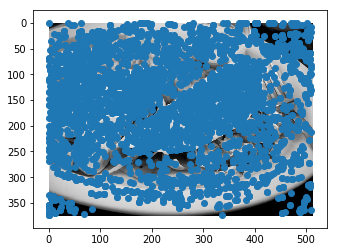

In [24]:
keypoints = assign_orientation(pyramid_peaks,pyramid_magnitude,pyramid_direction)

print("Plotting the keypoints...")
plt.imshow(I, cmap = 'gray')
plt.scatter(keypoints[:,2],keypoints[:,1])
plt.show()

# 4. Local Image Descriptor at KeyPoints

In [25]:
# Upscaling(Downscaling for first octave) the magnitude and direction pyramids to normal image size
def upscale(pyramid_magnitude,pyramid_direction):
    row,column = I.shape
    for oc in range(octaves_count):
        for sc in range(scale_count):
            
            # Resize the image dimensions
            pyramid_magnitude[oc][sc] = cv2.resize(pyramid_magnitude[oc][sc], dsize = (column,row))
            pyramid_direction[oc][sc] = cv2.resize(pyramid_direction[oc][sc], dsize = (column,row))
    
    return pyramid_magnitude, pyramid_direction

Plotting the scaled magnitude and directions matrices...


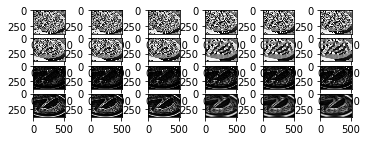

In [26]:
pyramid_magnitude,pyramid_direction = upscale(pyramid_magnitude,pyramid_direction)
print("Plotting the scaled magnitude and directions matrices...")
for oc in range(octaves_count):
    for sc in range(scale_count):
        ax = plt.subplot(2 * octaves_count,2 * scale_count, oc * (scale_count) + sc + 1)
        ax.imshow(pyramid_direction[oc][sc], cmap = 'gray')
        
        ax = plt.subplot(2 * octaves_count,2 * scale_count, 12 + oc * (scale_count) + sc + 1)
        ax.imshow(pyramid_magnitude[oc][sc], cmap = 'gray')

plt.show()

In [29]:
def keypoint_descriptor(keypoints, pyramid_magnitude, pyramid_direction):
    
    # Number of keypoints for a image
    count,_ = keypoints.shape
    
    # Pyramid of feature vectors for different octave levels
    descriptors = np.zeros([count, 128])
    
    # Actual Size of image
    max_row, max_col = I.shape
    
    for i in range(count):
        
        # 16 * 16 window 
        for row in range(-8, 8):
            for column in range(-8, 8):
                
                # convert the angle of the keypoint from degrees to radians
                theta = keypoints[i][3] * np.pi / 180.0
                
                # xrot and yrot for the circular window
                xrot = np.round((np.cos(theta) * row) - (np.sin(theta) * column))
                yrot = np.round((np.sin(theta) * row) + (np.cos(theta) * column))
                
                # Octave and scale of keypoints
                oc = keypoints[i][5]
                sc = keypoints[i][4]
                
                # x and y coordinates of the keypoints
                index_i = keypoints[i][1]
                index_j = keypoints[i][2]
                
                # 8*8 circular window for the gaussian weight
                gaussian_window = multivariate_normal(mean=[index_i,index_j], cov=[8,8])
                
                # clip the new indices between 0 and max_row or max_col
                index_x = int(np.clip((index_i + xrot),0,max_row-1))
                index_y = int(np.clip((index_j + yrot), 0, max_col-1))
    
                # Modified weight
                weight = pyramid_magnitude[oc][sc][index_x][index_y] * gaussian_window.pdf([index_i + xrot, index_j + yrot])
                
                # Modified angle
                angle = pyramid_direction[oc][sc][index_x][index_y] - keypoints[i][3]
                if angle < 0:
                    angle = 36 + angle
                    
                # bin index
                bin_idx = int(np.clip(np.floor((8.0 / 36) * angle), 0, 7))
                
                # Histogramed descriptors
                descriptors[i][32 * int((row + 8)/4) + 8 * int((column + 8)/4) + bin_idx] += weight
        
        # Normalized Histograms
        descriptors[i] = descriptors[i] / norm(descriptors[i])
        descriptors[i] = np.clip(descriptors[i], 0, 0.2)
        descriptors[i] = descriptors[i] / norm(descriptors[i])

    return descriptors

In [30]:
descriptors = keypoint_descriptor(keypoints, pyramid_magnitude, pyramid_direction)

In [37]:
print("Number of keypoints", len(descriptors))
print("Descriptors length is ", len(descriptors[0]))

Number of keypoints 3855
Descriptors length is  128


In [96]:
def DetectandCompute(I_):
    
    # Initialization parameters
    octaves_count = 4
    scale_count = 3
    sigma = 1.6
    size = 7
    
    # Image Path
    img = Image.open(I_).convert('L')
    I = np.array(img).astype('float64')

    # Compute Pyramids
    pyramid_image = pyramidImage(I)
    pyramid_gaussian_image = pyramidGaussian(pyramid_image,octaves_count, scale_count, sigma, size)
    pyramid_DoG = pyramidDoG(pyramid_gaussian_image)
    
    # 1. Scale Space Extrema
    pyramid_peaks = scale_space_peaks(pyramid_DoG)
    
    # 2. Keypoint Localization
    pyramid_peaks = HessianMatrix(pyramid_DoG,pyramid_peaks)
    
    # 3. Orientation Assignment
    pyramid_a, pyramid_b = pyramid_ab(pyramid_gaussian_image)
    pyramid_magnitude = magnitude(pyramid_a, pyramid_b)
    pyramid_direction = direction(pyramid_a, pyramid_b)
    keypoints = assign_orientation(pyramid_peaks,pyramid_magnitude,pyramid_direction)
    
    # 4. Image Descriptors
    pyramid_magnitude,pyramid_direction = upscale(pyramid_magnitude,pyramid_direction)
    descriptors = keypoint_descriptor(keypoints, pyramid_magnitude, pyramid_direction)
    
    return list(keypoints), descriptors.astype(float32)

## Keypoint matching

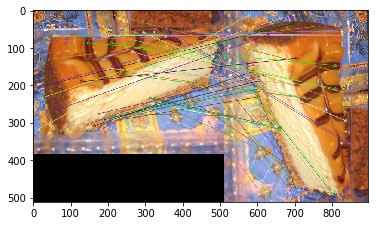

In [101]:
kp1, des1 = DetectandCompute("/Users/abhianshusingla/Desktop/Image1.jpg")
kp2, des2 = DetectandCompute("/Users/abhianshusingla/Desktop/Image2.jpg")

des1 = des1.astype(float32)
des2 = des2.astype(float32)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.05*n.distance:
        good.append([m])

i3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)

plt.imshow(cv2.cvtColor(i3, cv2.COLOR_BGR2RGB))
plt.show()